### 疾病引起原因模型解释

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve, auc, precision_score, recall_score,accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import eli5
from eli5.sklearn import PermutationImportance
import shap
from pdpbox import pdp,info_plots

plt.rcParams['font.sans-serif']=['SimHei']  # 让图形可以显示中文
plt.rcParams['axes.unicode_minus']=False

In [3]:
np.random.seed(123)

pd.options.mode.chained_assignment = None

In [4]:
dt = pd.read_csv("data/heart.csv")
dt.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


<ul>
    <li>age:该人的年龄
    <li>sex:该人的性别(1=男性,0=女性)
    <li>cp:胸痛经历(值1:典型心绞痛,值2:非典型心绞痛,值3:非心绞痛,值4:无症状)
    <li>trestbps:该人的静息血压(入院时为mmHg)
    <li>chol:人体胆固醇测量单位为mg/dl
    <li>fbs:该人的空腹血糖(>120mg/dl,1=true;0= false)
    <li>rested:静息心电图测量(0=正常,1=有STT波异常,2=按 Estes标准显示可能或明确的左心室肥厚)
    <li>thalach:达到了该人的最大心率
    <li>etang:运动诱发心绞痛(1=是;0=否)
    <li>oldspeak:运动相对于休息引起的ST段压低("ST"与ECG图上的位置有关)
    <li>slope:峰值运动ST段的斜率(值1:上升,值2:平坦,值3:下降)
    <li>ca:主要数量(0-3)
    <li>thal:称为地中海贫血的血液疾病(3=正常;6=固定缺陷;7=可逆缺陷)
    <li>target:心脏病(0=不,1=是)

In [5]:
dt.columns.values

array(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype=object)

In [6]:
#拿到当前所有的13个特征和1个标签 ，一共是14列 
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [7]:
#转换一下各个特征的属性，int——>str

dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

#    胸痛经历                                              
dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina' #典型心绞痛
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina' #非典型心绞痛
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain' #非心绞痛
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'  #无症状

#病人的静息血压
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml' #低压
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'#高压

#心电图测量
dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'#正常
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality' #有ST-T波异常
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'#按Estes标准显示可能或明确的左心室肥厚

#运动诱发心绞痛
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no' #否
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes' #是

#峰值运动后ST段心电图的斜率
dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'#上升
dt['st_slope'][dt['st_slope'] == 2] = 'flat' #平坦
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping' #下降

#称为地中海贫血的血液疾病
dt['thalassemia'][dt['thalassemia'] == 1] = 'normal' #正常
dt['thalassemia'][dt['thalassemia'] == 2] = 'fixed defect' #固定
dt['thalassemia'][dt['thalassemia'] == 3] = 'reversable defect'#可逆缺陷


In [8]:
dt.dtypes #除了int类型外，有很多的object类型，比如说sex chest_pain_type等

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

In [9]:
dt['sex'] = dt['sex'].astype('object')#男为1 ，女为0 
dt['chest_pain_type'] = dt['chest_pain_type'].astype('object') 
dt['fasting_blood_sugar'] = dt['fasting_blood_sugar'].astype('object')
dt['rest_ecg'] = dt['rest_ecg'].astype('object')
dt['exercise_induced_angina'] = dt['exercise_induced_angina'].astype('object')
dt['st_slope'] = dt['st_slope'].astype('object')
dt['thalassemia'] = dt['thalassemia'].astype('object')

In [11]:
#pandas的读热编码
dt = pd.get_dummies(dt) # prefix
dt.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_female,sex_male,chest_pain_type_0,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_greater than 120mg/ml,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_ST-T wave abnormality,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_no,exercise_induced_angina_yes,st_slope_0,st_slope_flat,st_slope_upsloping,thalassemia_0,thalassemia_fixed defect,thalassemia_normal,thalassemia_reversable defect
0,63,145,233,150,2.3,0,1,0,1,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0
1,37,130,250,187,3.5,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,1,0,0
2,41,130,204,172,1.4,0,1,1,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0
3,56,120,236,178,0.8,0,1,0,1,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,0
4,57,120,354,163,0.6,0,1,1,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0


In [12]:
# 切分数据集
X_train, X_test, y_train, y_test = train_test_split(dt.drop('target', 1), 
                                dt['target'], test_size = .2, random_state=10) 

In [13]:
model = RandomForestClassifier(max_depth=5)  # 建立模型
model.fit(X_train, y_train)  # 训练

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

- bootstrap=True是否使用bootstrap，默认是true，自助法，有放回的重采样
- “balanced” 模式自动调整权重，每类的权重为 n_samples / (n_classes * np.bincount(y))，即类别数的倒数除以每类样本数的占比。
- 树分裂的规则：gini系数，entropy熵,默认的是基尼系数
- max_depth=5：树的深度为5层
- max_features='auto'：int, float, string or None, optional (default=”auto”)查找最佳分裂所需考虑的特征数，
- int：分裂的最大特征数，
- float：分裂的特征占比，auto、sqrt：sqrt(n_features)，log2：log2(n_features)，None：n_features，

- max_leaf_nodes=None 最大叶子节点数；
- min_impurity_decrease=0 分裂的最小不纯度为0 
- n_estimators：随机森林中树的数量
- n_jobs : integer, optional (default=1)，并行job数，-1 代表全部
- oob_score : bool (default=False)，是否使用袋外（out-of-bag）样本估计准确度；
- random_state=None ，随机数种子，保持下一次运行不变
- verbose：控制树冗余
- warm_start : bool, optional (default=False)，如果设置为True，在之前的模型基础上预测并添加模型，否则，建立一个全新的森林；



In [14]:
estimator = model.estimators_[1]#只有一颗树
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease' #0代表没心脏病
y_train_str[y_train_str == '1'] = 'disease' #1代表有心脏病
y_train_str = y_train_str.values

In [16]:
export_graphviz(estimator, out_file='data/tree.dot', 

                feature_names = feature_names,  #特征变量 ，已被定义
                class_names = y_train_str, # 类别变量，已被定义
                rounded = True, proportion = True, #树节点为圆角矩形
                label='root',
                precision = 2, filled = True) #precision=2：每个节点的杂质，阈值和值属性的值中浮点数的精度位数； filled：填充满

# 使用系统命令转换为png（需要Graphviz）
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'],shell=True)
# dot:生成可视化图片的命令  
#-Tpng：指定图像类型是png
#tree.dot：out_file输出的文件名
#-o：output输出文件
#tree.png：输出文件名
#-Gdpi=600：图像每英寸含600个像素


# 显示在jupyter笔记本
from IPython.display import Image
Image(filename = 'data/tree.png')

In [30]:
# 预测结果
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:,1]
y_pred_bin = model.predict(X_test)

In [19]:
print("精确率：",precision_score(y_test, y_predict))   
print("召回率",recall_score(y_test, y_predict)) 

精确率： 0.7096774193548387
召回率 0.8461538461538461


In [20]:
confusion_matrix = confusion_matrix(y_test, y_pred_bin)
confusion_matrix

array([[26,  9],
       [ 4, 22]], dtype=int64)

In [38]:
def auc_plot(y, y_prob, thres=0.5, png_savename=0):
    """
    why: 能够知道模型的效果，AUC越高，则模型分辨正负样本的能力越好。
    功能: 画出AUC图
    y: 真实结果（标签/df型）
    y_prob：预测概率（浮点数）
    png_savename: 保存图片的名字，默认不保存
    return: AUC图
    """
    y_prediction = y_prob > thres  # 输出预测的结果
    # fpr：被错误分到正样本类别中真实的负样本所占所有负样本总数的比例
    # tpr：当前分到正样本中真实的正样本所占所有正样本的比例
    fpr, tpr, thres = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)  # 计算AUC
    # 画出AUC
    plt.plot(fpr, tpr, label="AUC = {0:.4f}".format(roc_auc), ms=100)
    plt.title("ROC曲线", fontsize=20)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('误判率', fontsize=15)
    plt.ylabel('命中率', fontsize=15)
    if png_savename != 0:
        plt.savefig("%s_AUC图.png" % png_savename, dpi=300)  # 保存AUC图, dpi清晰度，越大越清晰
    plt.show()
    print("Accuracy: {0:.2f}".format(accuracy_score(y, y_prediction)))  # 准确率

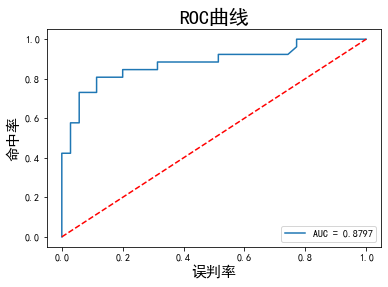

Accuracy: 0.79


In [41]:
auc_plot(y_test,y_pred_quant)

我们希望蓝色线条下面的面积能无限接近于1，则表示越好，AUC就是这个面积

In [42]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
# 求集成算法的特征重要度，加载所有特征
eli5.show_weights(perm, feature_names = X_test.columns.tolist())
#第一行的心绞痛的经历权重很高跟是否得心脏病很重要，中间的非心绞痛就跟心脏病和正常的贫血跟没关系

Weight,Feature
0.0393 ± 0.0445,thalassemia_fixed defect
0.0164 ± 0.0464,sex_male
0.0066 ± 0.0262,st_depression
0.0033 ± 0.0564,num_major_vessels
0.0033 ± 0.0245,st_slope_upsloping
0 ± 0.0000,rest_ecg_ST-T wave abnormality
0.0000 ± 0.0207,chest_pain_type_atypical angina
0 ± 0.0000,chest_pain_type_non-anginal pain
0 ± 0.0000,chest_pain_type_typical angina
0 ± 0.0000,fasting_blood_sugar_lower than 120mg/ml


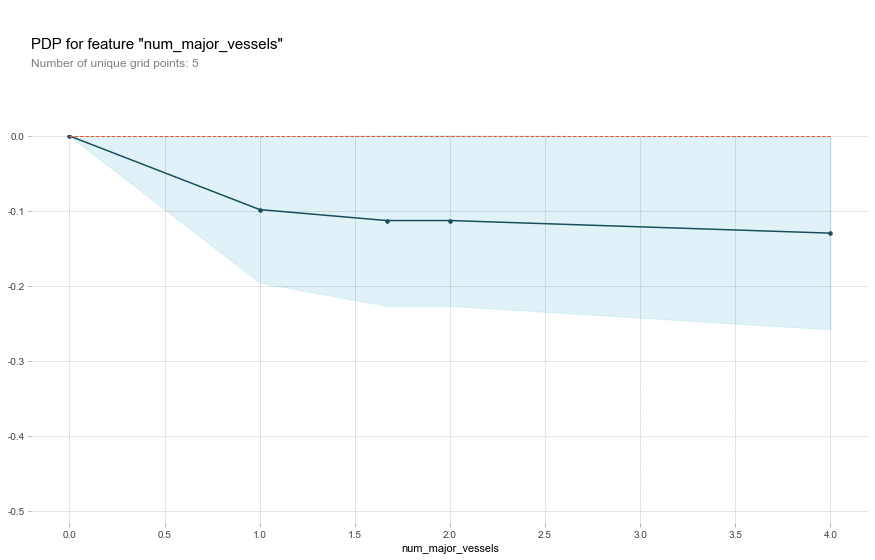

In [43]:
base_features = dt.columns.values.tolist()
base_features.remove('target') #删除标签，是否得心脏病，剩下的都是特征

feat_name = 'num_major_vessels' #主要血管数量
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()
#随着主要血管的数量增加，心脏病的概率降低,也就是该特征对结果起到了抑制的作用。
#这是有道理的，因为这意味着更多的血液可以进入心脏。

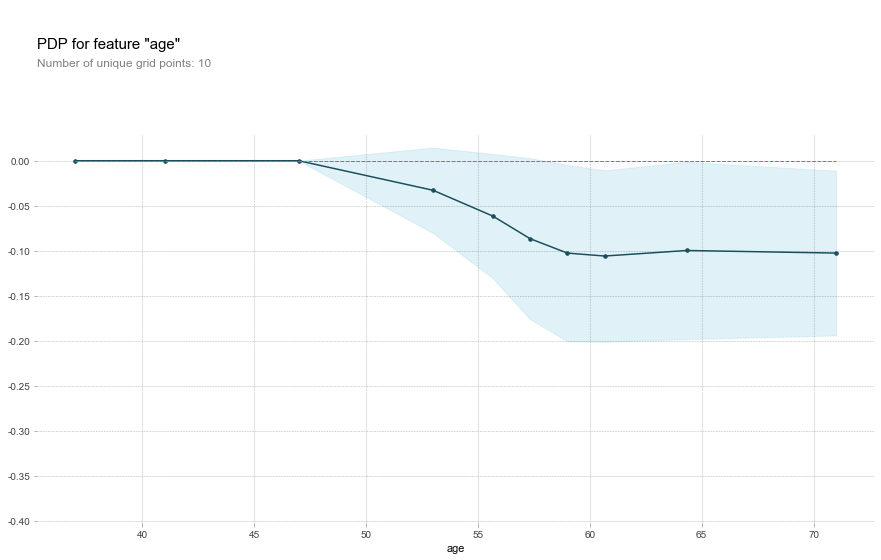

In [44]:
feat_name = 'age'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()
#随着年龄的升高，心脏病越小

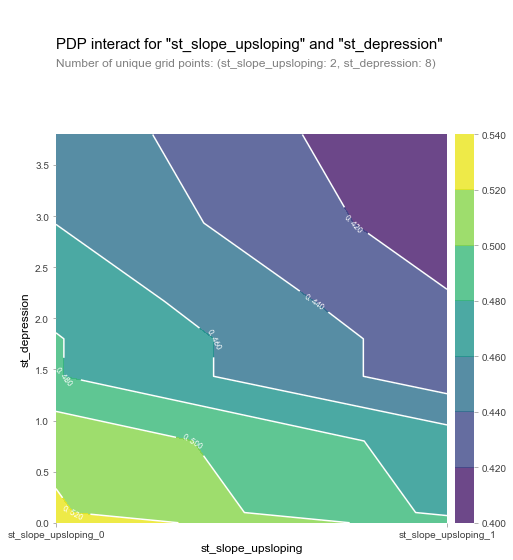

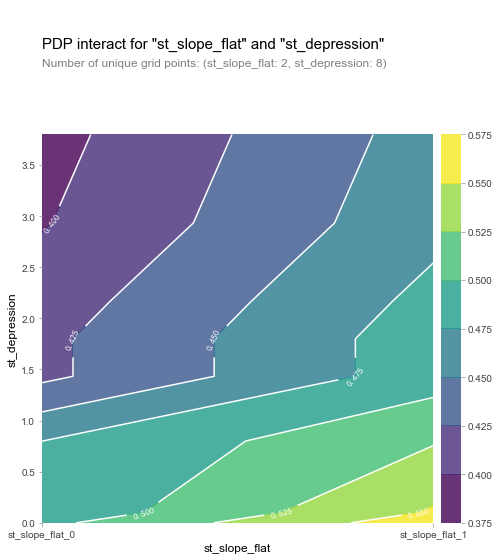

In [46]:
inter1 = pdp.pdp_interact(model=model, dataset=X_test,
                         model_features=base_features,
                         features=['st_slope_upsloping','st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_upsloping','st_depression'],
                     plot_type='contour')
plt.show()

inter1 = pdp.pdp_interact(model=model, dataset=X_test,
                         model_features=base_features,
                         features=['st_slope_flat','st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_flat','st_depression'],
                     plot_type='contour')
plt.show()

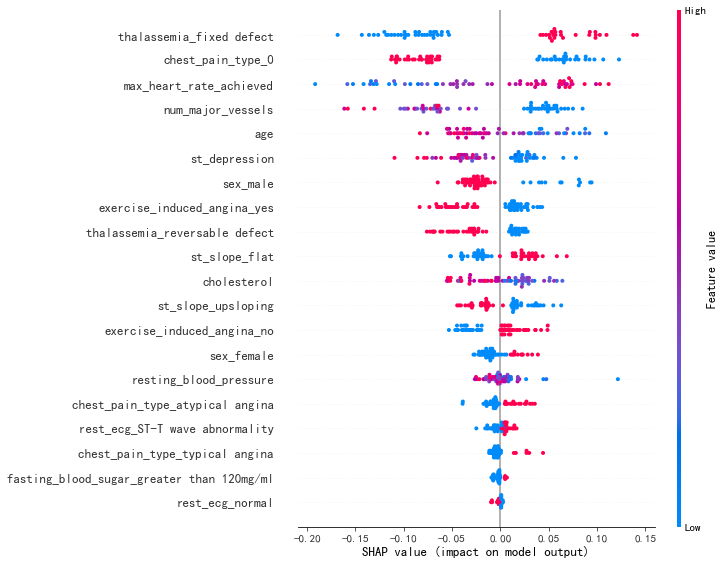

In [47]:
#chest_pain_type：心绞痛从蓝变红，越来越大，代表越来越严重
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

In [48]:
def heart_disease_risk_factors(model, patient):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient) #patient患者

In [49]:
data_for_prediction = X_test.iloc[1,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)